In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gluonts
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.rolling_dataset import generate_rolling_dataset, StepStrategy
from gluonts.evaluation import make_evaluation_predictions, Evaluator
os.chdir('/home/reffert/DeepAR_InfluenzaForecast')
from PythonFiles.model import model, preprocessing, split_forecasts_by_week, plot_coverage
from PythonFiles.Configuration import Configuration
config = Configuration()
df = pd.read_csv("Influenza.csv", sep=',')

/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/gluonts/model/simple_feedforward/__init__.py:18: FutureWarning: The module gluonts.model.simple_feedforward has been moved to gluonts.mx.model.simple_feedforward. In GluonTS v0.12 it will be no longer possible to use the old path. Try to use 'from gluonts.mx import SimpleFeedForwardEstimator'.
  warnings.warn(


In [2]:
locations = list(df.location.unique())

# Process the df into a uniformly spaced df
df = df.loc[df.location.isin(locations), ["value", 'location', 'date']]
corrected_df = preprocessing(config, df, check_count=False, output_type="corrected_df")
#TODO --> maybe put the following code within preprocessing...

# seperate the intervals for training and testing
train_set_df = corrected_df.loc[(corrected_df.index <= config.train_end_time) &
                          (corrected_df.index >= config.train_start_time),:]

test_set_df = corrected_df.loc[(corrected_df.index >= config.train_start_time) &
                         (corrected_df.index <= config.test_end_time),:]

# Format the train and test_set into a PandasDataset
train_set = PandasDataset.from_long_dataframe(dataframe=train_set_df,
                                              item_id='location',
                                              target="value",
                                              freq=config.freq)

test_set = PandasDataset.from_long_dataframe(dataframe=test_set_df,
                                             item_id='location',
                                             target="value",
                                             freq=config.freq)

# Determine the Starting and ending time of the test_set_df
start_time = min(test_set_df.index.difference(train_set_df.index))
end_time = max(test_set_df.index.difference(train_set_df.index))
test_set = generate_rolling_dataset(dataset=test_set,
                                    strategy = StepStrategy(prediction_length=4, step_size=1),
                                    start_time = pd.Period(start_time, config.freq),
                                    end_time = pd.Period(end_time, config.freq)
                                   )

In [3]:
models_dict = {"DeepAR":config.deeparestimator, "FFNN":config.feedforwardestimator}
evaluator_df_dict = {}
for key in models_dict.keys():
    forecasts, tss = model(config, train_set, test_set, models_dict[key])

    # Splitting the forecasts into their weekly contribution
    split_tss = split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[1]

    forecast_dict ={1 : split_forecasts_by_week(config, forecasts, tss, locations, 1, equal_time_frame=True)[0],
                    2 : split_forecasts_by_week(config, forecasts, tss, locations, 2, equal_time_frame=True)[0],
                    3 : split_forecasts_by_week(config, forecasts, tss, locations, 3, equal_time_frame=True)[0],
                    4 : split_forecasts_by_week(config, forecasts, tss, locations, 4, equal_time_frame=True)[0]}
    # Evaluation
    evaluator = Evaluator(quantiles=config.quantiles)
    evaluator_df = pd.DataFrame()
               
    # iterate over the 4 different week-aheads
    for forecast in forecast_dict.values():
        agg_metrics, item_metrics = evaluator(split_tss, forecast)
        d = {key for key in forecast_dict if forecast_dict[key] == forecast}
        for location in locations[:]:
            item_metrics.loc[item_metrics.item_id == f"{location}", "item_id"] = f"{location} {d}"
            evaluator_df = pd.concat([evaluator_df, item_metrics[item_metrics.item_id == f"{location} {d}"]])
        agg_metrics["item_id"] = f"aggregated {d}"
        evaluator_df = pd.concat([evaluator_df, pd.DataFrame(agg_metrics,index=[0])])
    evaluator_df_dict[key] = evaluator_df

100%|██████████| 50/50 [00:06<00:00,  8.25it/s, epoch=4/4, avg_epoch_loss=0.822]
Running evaluation: 411it [00:01, 408.39it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 392.77it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 386.24it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
  return arr.astype(dtype, copy=True)
Running evaluation: 411it [00:01, 397.03it/s]
/home/reffert/.conda/envs/TEST_ENV/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1181: UserWarning: Warning: converting a masked element to nan.
 

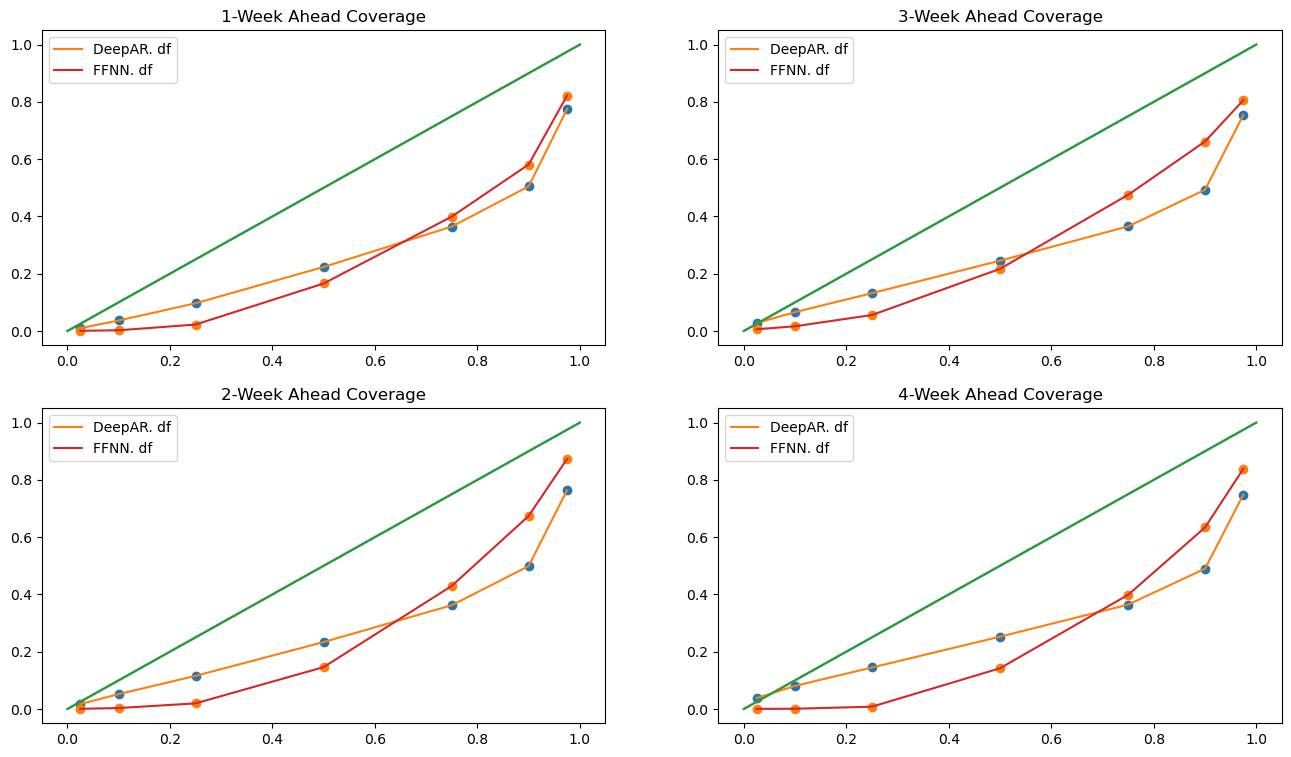

In [4]:
plot_coverage(config, evaluator_df_dict)